# England Crime Association Rules
The aim here is to see if there are any associations between the reported aspects of crime, such as Month of Year, Location, Crime type etc.
This will be done in Pyspark due to the size of the data but it will still be possible to execute on a local cluster.

The data can be downloaded from here: https://data.police.uk/data/.

The date range for this data is September 2015 - August 2018 and all constabularies in England were selected (excluding British Transport Police)

In [328]:
import glob
import os
import calendar
import pandas as pd
import matplotlib.pyplot as plt

#### Set up Spark
Running Spark locally

In [329]:
from pyspark import SparkContext
from pyspark.ml.fpm import FPGrowth
from pyspark.sql import SQLContext, SparkSession

In [330]:
spark = SparkSession.builder\
        .master("local")\
        .appName("Crime Assocations")\
        .getOrCreate()

In [331]:
sc = spark.sparkContext

In [332]:
# Set up a SQL Context
sqlCtx = SQLContext(sc)

In [176]:
#sc.stop()

## Load Data into Spark

In [333]:
import pyspark.sql.functions as F

The police data comes in several csv files with a folder for each Month-Year. We will concatenate these

In [334]:
# Using a glob here to get all of the locations of the files we need
file_locations = glob.glob(os.getcwd() + "/all_data/*/*.csv")

In [335]:
police_data_df = sqlCtx.read.format("csv").option("header", "true").load(file_locations)

#### Inspecting the data

In [184]:
police_data_df.show(5)

+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|            Crime ID|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|          Crime type|Last outcome category|Context|
+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|5ac3055389bf0d7f7...|2017-07|Metropolitan Poli...|Metropolitan Poli...| 0.763024|51.210698|On or near Wind H...|E01024033|        Ashford 002E|         Other theft| Investigation com...|   null|
|db2ba97b31d87e77e...|2017-07|Metropolitan Poli...|Metropolitan Poli...| 1.185594|52.000179|On or near Main Road|E01029873|        Babergh 011B|        Public order| Investigation com...|   null|
|                nul

In [185]:
police_data_df.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)



In [209]:
num_rows = police_data_df.count()

In [210]:
num_rows

18376429

## Cleaning the Data

In [336]:
# The month column in the data is actually a Year-Month, here we will split that on the - delimiter and create a Year and Month_of_Year Column
month_year_split = F.split(police_data_df['Month'], '-')
police_data_df = police_data_df.withColumn('Year', month_year_split.getItem(0))\
                .withColumn('Month_of_Year', month_year_split.getItem(1))

In [337]:
# Ensure that both of the new columns created are integer and not string types
police_data_df = police_data_df.withColumn("Month_of_Year", police_data_df.Month_of_Year.cast("int"))
police_data_df = police_data_df.withColumn("Year", police_data_df.Year.cast("int"))

In [338]:
# Check this worked
police_data_df

DataFrame[Crime ID: string, Month: string, Reported by: string, Falls within: string, Longitude: string, Latitude: string, Location: string, LSOA code: string, LSOA name: string, Crime type: string, Last outcome category: string, Context: string, Year: int, Month_of_Year: int]

In [339]:
# In order to convert the month from a number representing the month index, this function has been created to map that index
# to its 3 letter abbreviation
get_month_name = F.udf(lambda x: calendar.month_abbr[x])

In [340]:
# Apply get_month_name to the Month of Year Column
police_data_df = police_data_df.withColumn("Month_of_Year", get_month_name(police_data_df["Month_of_Year"]))

In [341]:
# Now remove the On or near part of the string in Location as it adds no information
police_data_df = police_data_df.withColumn('Location', F.regexp_replace('Location', 'On or near ', ''))

## Exploratory Analysis

In [202]:
# Look at most common crimes
crime_type_counts = police_data_df\
                    .groupBy(police_data_df['Crime type'])\
                    .count()\
                    .sort(F.col("count").desc())\
                    .toPandas()

In [218]:
crime_type_counts_series = crime_type_counts.set_index("Crime type").squeeze()
crime_type_counts_series = crime_type_counts_series*100/num_rows

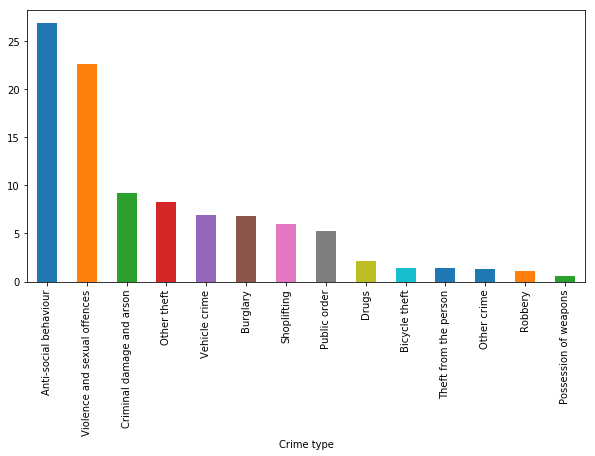

In [219]:
plt.figure(figsize=(10, 5))
crime_type_counts_series.plot(kind = "bar")
plt.show()

Anti-social behaviour makes up about 27% of crime in England - which is expected... It is concerning that violence and sexual offences is in second place

In [220]:
# Find the areas where crime occurs the most
crime_area_counts = police_data_df\
                    .groupBy(police_data_df['LSOA name'])\
                    .count()\
                    .sort(F.col("count").desc())\
                    .toPandas()

In [225]:
crime_area_counts_series = crime_area_counts.set_index("LSOA name").squeeze().head(15)

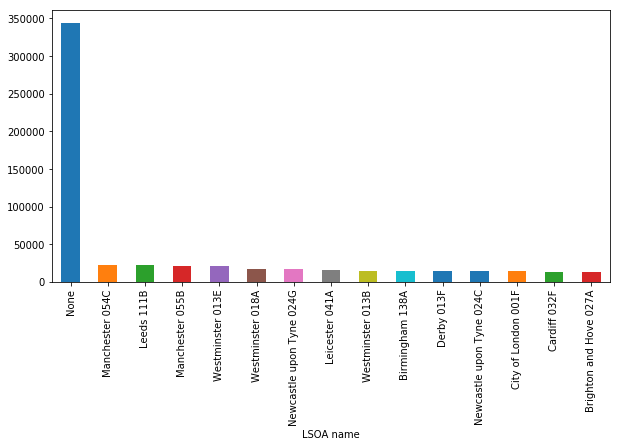

In [231]:
plt.figure(figsize=(10, 5))
crime_area_counts_series.plot(kind = "bar")
plt.show()

There appear to be a large amount of NAs, so let's look at the distribution without that

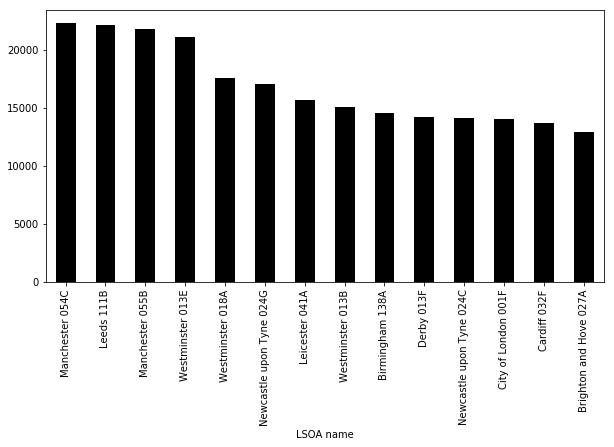

In [236]:
plt.figure(figsize=(10, 5))
crime_area_counts_series[1:].plot(kind = "bar", color="k")
plt.show()

Deansgate, Manchester is Manchester 054C, don't go there

In [275]:
# Find the months where the most crimes have occurred
crime_month_counts = police_data_df\
                    .groupBy(police_data_df['Month_of_Year'])\
                    .count()\
                    .sort(F.col("count").desc())\
                    .toPandas()

In [276]:
# Convert Month_of_Year to a categorical variable
crime_month_counts["Month_of_Year"] = pd.Categorical(crime_month_counts["Month_of_Year"], 
                                                     categories=["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                                                                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

In [277]:
crime_month_counts_series = crime_month_counts\
                            .sort_values(by="Month_of_Year")\
                            .set_index("Month_of_Year")\
                            .squeeze()

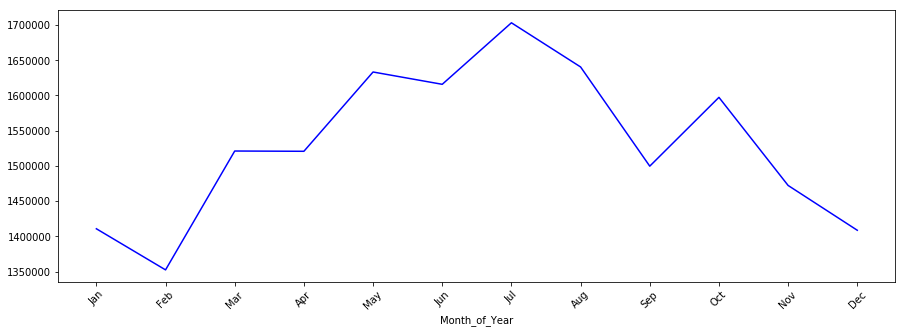

In [278]:
plt.figure(figsize=(15, 5))
ax = crime_month_counts_series.plot(kind = "line", color="b")
ax.set_xticks(range(0, len(crime_month_counts_series.index)))
ax.set_xticklabels(list(crime_month_counts_series.index), rotation=45)
plt.show()

Lets find out what the NAs are being caused by

In [279]:
null_lsoa = police_data_df\
                    .where(police_data_df["LSOA name"].isNull())

In [289]:
null_lsoa.count()/num_rows

0.018709130049151552

So only about two percent of the data has no location information, we can exclude this

## Feature Engineering & Modelling

In [342]:
# Remove the crimes with no crime ID and no LSOA Information.
police_data_modelling = police_data_df.filter(police_data_df["Crime ID"].isNotNull() & police_data_df["LSOA name"].isNotNull())
# Select the Features of interest
police_data_modelling = police_data_modelling[["Falls within", "Location", "LSOA name", "Crime type", "Last outcome category", "Month_of_Year"]]

In [343]:
police_data_modelling.show(3)

+--------------------+--------------+--------------------+-------------+---------------------+-------------+
|        Falls within|      Location|           LSOA name|   Crime type|Last outcome category|Month_of_Year|
+--------------------+--------------+--------------------+-------------+---------------------+-------------+
|Metropolitan Poli...|Wind Hill Lane|        Ashford 002E|  Other theft| Investigation com...|          Jul|
|Metropolitan Poli...|     Main Road|        Babergh 011B| Public order| Investigation com...|          Jul|
|Metropolitan Poli...|   Hazel Grove|Barking and Dagen...|Bicycle theft| Status update una...|          Jul|
+--------------------+--------------+--------------------+-------------+---------------------+-------------+
only showing top 3 rows



The FP growth algorithm (like association rules), needs the items to be concatenated into a list/array of "transactions".

In [344]:
police_item_set = police_data_modelling.withColumn("items", F.array(police_data_modelling["Falls within"],
                                                                    police_data_modelling["Location"],
                                                                    police_data_modelling["LSOA name"],
                                                                    police_data_modelling["Crime type"],
                                                                    police_data_modelling["Last outcome category"],
                                                                    police_data_modelling["Month_of_Year"]))
police_item_set = police_item_set.select("items")
police_item_set = police_item_set.withColumn("id", F.monotonically_increasing_id())

In [345]:
police_item_set.show()

+--------------------+---+
|               items| id|
+--------------------+---+
|[Metropolitan Pol...|  0|
|[Metropolitan Pol...|  1|
|[Metropolitan Pol...|  2|
|[Metropolitan Pol...|  3|
|[Metropolitan Pol...|  4|
|[Metropolitan Pol...|  5|
|[Metropolitan Pol...|  6|
|[Metropolitan Pol...|  7|
|[Metropolitan Pol...|  8|
|[Metropolitan Pol...|  9|
|[Metropolitan Pol...| 10|
|[Metropolitan Pol...| 11|
|[Metropolitan Pol...| 12|
|[Metropolitan Pol...| 13|
|[Metropolitan Pol...| 14|
|[Metropolitan Pol...| 15|
|[Metropolitan Pol...| 16|
|[Metropolitan Pol...| 17|
|[Metropolitan Pol...| 18|
|[Metropolitan Pol...| 19|
+--------------------+---+
only showing top 20 rows



## Modelling: Create the FP growth algorithm
For Association rules

In [346]:
int(0.01*num_rows)

183764.29

In [347]:
# Use a low support as we have a large dataset
fpGrowth = FPGrowth(itemsCol="items", minSupport=0.01, minConfidence=0.5)
model = fpGrowth.fit(police_item_set)

In [348]:
model.save('crime_association_rules')

In [349]:
# Display frequent itemsets.
model.freqItemsets.show()

+--------------------+-------+
|               items|   freq|
+--------------------+-------+
|[Investigation co...|5891360|
|[Violence and sex...|4044715|
|[Violence and sex...| 870331|
|[Unable to prosec...|2584597|
|[Unable to prosec...|1606798|
|[Metropolitan Pol...|2332585|
|[Metropolitan Pol...| 633002|
|[Metropolitan Pol...| 359959|
|[Metropolitan Pol...|1018701|
|[Status update un...|1673528|
|[Status update un...| 495868|
|[Status update un...| 769943|
|[Criminal damage ...|1660452|
|[Criminal damage ...| 208735|
|[Criminal damage ...| 163639|
|[Criminal damage ...| 181178|
|[Criminal damage ...|1040286|
|       [Other theft]|1478664|
|[Other theft, Una...| 161679|
|[Other theft, Sta...| 207261|
+--------------------+-------+
only showing top 20 rows



In [350]:
# Display generated association rules.
rules = model.associationRules

In [352]:
# Show all of the association rules
rules.show(truncate=False)

+-----------------------------------------------------------+-----------------------------------------------+------------------+
|antecedent                                                 |consequent                                     |confidence        |
+-----------------------------------------------------------+-----------------------------------------------+------------------+
|[Vehicle crime]                                            |[Investigation complete; no suspect identified]|0.7025339145608448|
|[Nottinghamshire Police]                                   |[Investigation complete; no suspect identified]|0.5031396256585671|
|[West Yorkshire Police, Unable to prosecute suspect]       |[Violence and sexual offences]                 |0.6077604018402373|
|[Vehicle crime, Metropolitan Police Service]               |[Status update unavailable]                    |0.5814401324385522|
|[Northumbria Police]                                       |[Investigation complete; no suspect 

So what does this mean? The highest confidence rule is (Bicycle Theft -> Investigation complete; no suspect identified). This means that 73% of the time, when a Bike theft occured, no suspect was found.

The second and third highest confidence rules give similar statements about burglary and vehicle crime.

Another interesting set of rules are where there are crimes where the suspect was unable to be prosecuted in March, June and July "implies" that it is likely (around 62% of the time) to be a Violence and/or sexual offence.

In [305]:
#' Minor tidying to save as csv
rules_df = rules.withColumn("antecedent" ,F.concat_ws(",", rules["antecedent"]))\
          .withColumn("consequent" ,F.concat_ws(",", rules["consequent"]))

In [310]:
rules_df.write.csv('crime_rules.csv')

In [353]:
sc.stop()